Simplified image-based implementation of JEPA (Joint-Embedding Predictive Architecture)

Paper: https://arxiv.org/pdf/2301.08243.pdf
JEPA (Joint-Embedding Predictive Architecture) is an alternative to auto-regressive LLM architectures pioneered by Prof. Yann LeCun. I-JEPA predicts image segment representations (Target) based on representations of other segments within the same image (Context)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from IPython.display import display
import ipywidgets as widgets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.interpolate import make_interp_spline

class SimplifiedViT(nn.Module):
    """Simplified Vision Transformer (ViT) implementation"""
    def __init__(self, image_size, patch_size, dim, depth, heads, mlp_dim, in_channels):
        super(SimplifiedViT, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size

        # Embed patches to vectors
        self.patch_embedding = nn.Linear(patch_dim, dim)
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, dim))

        # Transformer encoder layers
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim))

        # Layer normalization
        self.norm = nn.LayerNorm(dim)

    def forward(self, img):
        # Handle different input shapes
        if img.dim() == 3 and img.size(1) == self.num_patches:
            x = img
        else:
            if img.dim() == 3:
                img = img.unsqueeze(1)
            
            b, c, h, w = img.shape
            assert h == w == self.image_size, f"Input image size ({h}*{w}) doesn't match model ({self.image_size}*{self.image_size})."
            assert c == self.in_channels, f"Input channels {c} doesn't match expected {self.in_channels}"

            # Convert image to patches
            x = img.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
            x = x.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
            x = x.permute(0, 2, 1, 3).contiguous().view(b, -1, c * self.patch_size * self.patch_size)
            x = self.patch_embedding(x)

        # Add position embeddings
        x = x + self.pos_embedding

        # Pass through transformer layers
        for layer in self.layers:
            x = layer(x)

        # Apply final normalization
        x = self.norm(x)
        return x

class IJEPA(nn.Module):
    """Simplified IJEPA (Image-based Joint-Embedding Predictive Architecture)"""
    def __init__(self, image_size, patch_size, dim, context_depth, predictor_depth, heads, mlp_dim, in_channels):
        super(IJEPA, self).__init__()
        # Context and target encoders (sharing architecture but not weights)
        self.context_encoder = SimplifiedViT(image_size, patch_size, dim, context_depth, heads, mlp_dim, in_channels)
        self.target_encoder = SimplifiedViT(image_size, patch_size, dim, context_depth, heads, mlp_dim, in_channels)

        # Predictor network
        predictor_layers = []
        for _ in range(predictor_depth):
            predictor_layers.extend([
                nn.Linear(dim, dim),
                nn.GELU(),
                nn.LayerNorm(dim)
            ])
        self.predictor = nn.Sequential(*predictor_layers)
        
        self.patch_size = patch_size
        self.image_size = image_size
        self.num_patches = (image_size // patch_size) ** 2
        self.in_channels = in_channels

        # Decoder for visualizing predictions
        self.decoder = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, in_channels * patch_size * patch_size),
            nn.Sigmoid()
        )

    def forward(self, context, target):
        # Encode context and target
        context_features = self.context_encoder(context)
        with torch.no_grad():
            target_features = self.target_encoder(target)
        
        # Predict target features from context
        predicted_features = self.predictor(context_features)
        
        return predicted_features, target_features

    def predict_target_features(self, features):
        # Decode features to image patches
        patches = self.decoder(features)
        
        b, n, _ = patches.shape
        patches = patches.view(b, n, self.in_channels, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 1, 3, 4)
        
        # predict image from patches
        images = patches.contiguous().view(b, self.in_channels, self.image_size, self.image_size)
        return images

def generate_masks(image, patch_size, mask_size_ratio=0.6, border_width=1):
    """Randomly generate square-shaped masks for context and target"""
    b, c, h, w = image.shape
    num_patches = h // patch_size
    mask_size = max(1, int(num_patches * mask_size_ratio))
    
    patches = image.view(b, c, num_patches, patch_size, num_patches, patch_size)
    patch_means = patches.mean(dim=(1, 3, 5))
    
    masks = []
    for i in range(b):
        # Find the patch with maximum intensity
        max_patch = torch.argmax(patch_means[i].view(-1))
        max_y, max_x = max_patch // num_patches, max_patch % num_patches
        
        # Center the mask around the maximum intensity patch
        start_y = max(0, min(num_patches - mask_size, max_y - mask_size // 2))
        start_x = max(0, min(num_patches - mask_size, max_x - mask_size // 2))
        
        mask = torch.zeros(h, w, dtype=torch.float, device=image.device)
        
        # Square-shaped mask
        mask[start_y*patch_size:(start_y+mask_size)*patch_size, 
             start_x*patch_size:(start_x+mask_size)*patch_size] = 1
        
        # Add blue border
        mask[start_y*patch_size:(start_y+mask_size)*patch_size, 
             start_x*patch_size:start_x*patch_size+border_width] = 2  # Left border
        mask[start_y*patch_size:(start_y+mask_size)*patch_size, 
             (start_x+mask_size)*patch_size-border_width:(start_x+mask_size)*patch_size] = 2  # Right border
        mask[start_y*patch_size:start_y*patch_size+border_width, 
             start_x*patch_size:(start_x+mask_size)*patch_size] = 2  # Top border
        mask[(start_y+mask_size)*patch_size-border_width:(start_y+mask_size)*patch_size, 
             start_x*patch_size:(start_x+mask_size)*patch_size] = 2  # Bottom border
        
        masks.append(mask)
    
    return torch.stack(masks).unsqueeze(1)

def train(model, dataloader, optimizer, device, num_epochs):
    """Train and live preview logic"""
    model.train()
    criterion_features = nn.MSELoss(reduction='sum')
    criterion_reconstruction = nn.MSELoss(reduction='sum')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    losses, feature_losses, reconstruction_losses, times, learning_rates = [], [], [], [], []
    start_time = time.time()
    
    total_batches = len(dataloader) * num_epochs
    
    progress_bar = tqdm(total=total_batches, desc="Training", unit="batch")
    out = widgets.Output()
    display(out)
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    plt.close(fig)
    
    for epoch in range(num_epochs):
        epoch_loss = epoch_feature_loss = epoch_reconstruction_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            
            # Generate masks for this batch
            mask = generate_masks(data, model.patch_size)
            
            context_mask = (mask == 0).float()
            target_mask = (mask == 1).float()
            border_mask = (mask > 1).float()
            
            # Create context and target
            context = data * context_mask + 0.8 * target_mask + torch.tensor([0.0, 0.0, 1.0]).view(1, 3, 1, 1).to(device) * border_mask
            target = data * target_mask + 0.8 * context_mask + torch.tensor([0.0, 0.0, 1.0]).view(1, 3, 1, 1).to(device) * border_mask
            
            optimizer.zero_grad()
            
            # Forward pass
            pred_features, target_features = model(context, target)
            
            # Prepare masks for loss calculation
            target_mask_patches = target_mask.view(target_mask.size(0), target_mask.size(1), -1, model.patch_size, model.patch_size).any(dim=(3, 4)).float()
            target_mask_patches = target_mask_patches.view(target_mask_patches.size(0), -1, 1)
            
            # Calculate losses
            pred_features_masked = pred_features * target_mask_patches
            target_features_masked = target_features * target_mask_patches
            
            loss_features = criterion_features(pred_features_masked, target_features_masked) / (target_mask_patches.sum() * pred_features.size(-1) + 1e-6)
            
            pred_image = model.predict_target_features(pred_features)
            loss_reconstruction = criterion_reconstruction(pred_image * target_mask, data * target_mask) / (target_mask.sum() + 1e-6)
            
            loss = loss_features + 0.1 * loss_reconstruction
            
            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update running losses
            epoch_loss += loss.item()
            epoch_feature_loss += loss_features.item()
            epoch_reconstruction_loss += loss_reconstruction.item()
            
            # Update target encoder with momentum
            momentum = 0.996 + (1.0 - 0.996) * (epoch / num_epochs)
            for param, target_param in zip(model.context_encoder.parameters(), model.target_encoder.parameters()):
                target_param.data = momentum * target_param.data + (1 - momentum) * param.data
            
            progress_bar.update(1)
            progress_bar.set_postfix({"Epoch": epoch+1, "Loss": f"{loss.item():.4f}"})
            
            # Visualize (live preview)
            if batch_idx % 2 == 0:
                with out:
                    out.clear_output(wait=True)
                    
                    with torch.no_grad():
                        combined_image = context * context_mask + pred_image * target_mask + torch.tensor([0.0, 0.0, 1.0]).view(1, 3, 1, 1).to(device) * border_mask
                    
                    for i, (title, img) in enumerate([('Original', data.repeat(1, 3, 1, 1)), ('Context (Masked)', context), ('Target (Masked)', target), ('Predicted', combined_image)]):
                        axs[i].clear()
                        axs[i].imshow(img[0].permute(1, 2, 0).detach().cpu(), vmin=0, vmax=1)
                        axs[i].set_title(title)
                        axs[i].axis('off')
                    
                    plt.tight_layout()
                    display(fig)
        
        # Compute epoch averages and update lists
        avg_loss = epoch_loss / len(dataloader)
        avg_feature_loss = epoch_feature_loss / len(dataloader)
        avg_reconstruction_loss = epoch_reconstruction_loss / len(dataloader)
        losses.append(avg_loss)
        feature_losses.append(avg_feature_loss)
        reconstruction_losses.append(avg_reconstruction_loss)
        times.append(time.time() - start_time)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        scheduler.step(avg_loss)
        
        progress_bar.set_postfix({"Epoch": epoch+1, "Avg Loss": f"{avg_loss:.4f}"})
    
    progress_bar.close()
    return losses, feature_losses, reconstruction_losses, times, learning_rates

# Main
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Transform data to tensors
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load MNIST dataset
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

    # Initialize model
    model = IJEPA(image_size=28, patch_size=4, dim=256, context_depth=6, predictor_depth=6, heads=8, mlp_dim=512, in_channels=3).to(device)

    # Set up optimizer
    optimizer = optim.AdamW(
        list(model.context_encoder.parameters()) + 
        list(model.predictor.parameters()) + 
        list(model.decoder.parameters()), 
        lr=1e-3, 
        weight_decay=1e-4
    )
    
    num_epochs = 2
    losses, feature_losses, reconstruction_losses, times, learning_rates = train(model, train_loader, optimizer, device, num_epochs)

Training:   0%|          | 0/1876 [00:00<?, ?batch/s]

Output()

<Figure size 640x480 with 0 Axes>

In [20]:
def plots(losses, feature_losses, reconstruction_losses):
    """
    Plot training metrics: Loss vs Epoch and Loss Ratio vs Epoch
    
    Args:
    losses (list): Total losses for each epoch
    feature_losses (list): Feature losses for each epoch
    reconstruction_losses (list): Reconstruction losses for each epoch
    """
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    
    # Loss vs Epoch
    axs[0].plot(range(1, len(losses) + 1), losses, label='Total Loss')
    axs[0].plot(range(1, len(feature_losses) + 1), feature_losses, label='Feature Loss')
    axs[0].plot(range(1, len(reconstruction_losses) + 1), reconstruction_losses, label='Prediction Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Loss vs Epoch')
    axs[0].legend()
    
    # Loss Ratio vs Epoch
    loss_ratios = [r / f for r, f in zip(reconstruction_losses, feature_losses)]
    axs[1].plot(range(1, len(loss_ratios) + 1), loss_ratios)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Prediction Loss / Feature Loss')
    axs[1].set_title('Loss Ratio vs Epoch')
    
    plt.tight_layout()  # Corrected spelling here
    plt.show()

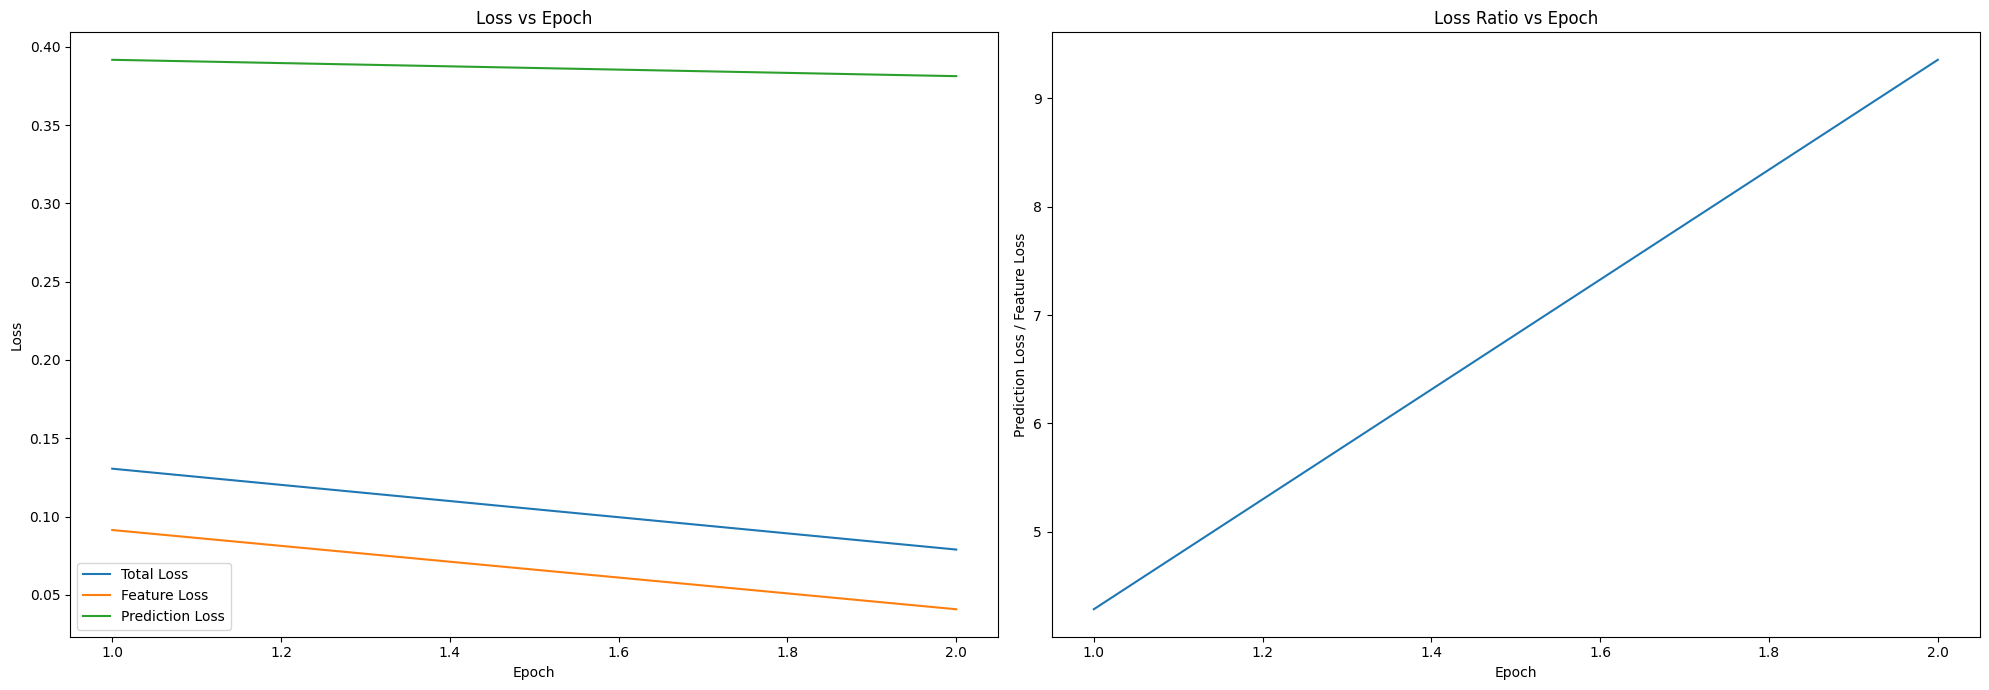

In [21]:
plots(losses, feature_losses, reconstruction_losses)